In [1]:

from dotenv import load_dotenv
import sys, os
sys.path.append('../')
from utilities.seed import seed_everything
seed_everything()
load_dotenv('../.env')

EXPERIMENT_DIR=os.getenv('EXPERIMENT_DIR')

## Experiment Settings

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

test_df = pd.read_csv(os.getenv('TEST_CSV'))
print(f"[INFO] Test Dataset Count : {len(test_df)}")

[INFO] Test Dataset Count : 40


## Dataset Setting

/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:63: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @amp.custom_fwd(cast_inputs=torch.float32)
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:89: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:131: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @amp.custom_fwd(cast_inputs=torch.float32)
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:140: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated

torch.Size([8, 1, 224, 224]) torch.Size([8, 1, 224, 224])


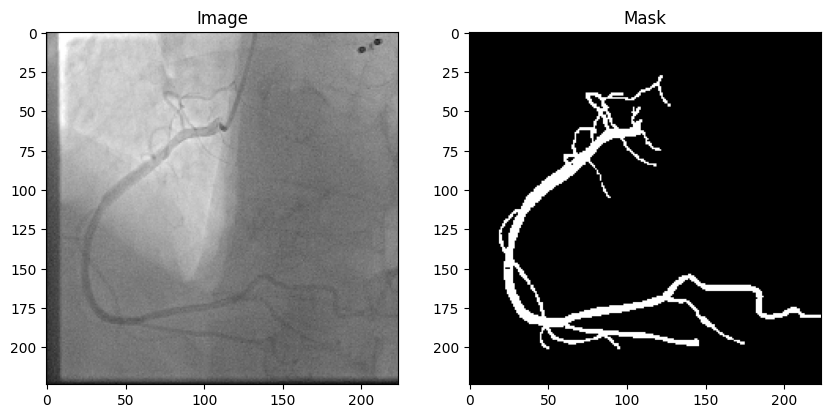

In [3]:
from torch.utils.data import DataLoader
from utilities.datasets import CAG_Dataset
from Args import Args_Valid_Loader
Test_Dataset = CAG_Dataset(
    df=test_df,
    image_dir=os.getenv('IMAGE_DIR'),
    mask_dir=os.getenv('MASK_DIR'),
    default_transform = Args_Valid_Loader._get_default_transform(),
    # Prompt_Args = {
    #     "n_shot" : 3
    # }
)

Test_Loader = DataLoader(
    Test_Dataset,
    batch_size=Args_Valid_Loader.valid_bs,
    shuffle=Args_Valid_Loader.shuffle,
    num_workers=Args_Valid_Loader.num_workers,
    pin_memory=Args_Valid_Loader.pin_memory,
)

sample_imgs, sample_masks = next(iter(Test_Loader))
print(sample_imgs.shape, sample_masks.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_imgs[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_masks[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Mask')
plt.show()

# Model Setting

## FineTuning

In [4]:
# from Args import Args_experiments
# from models.DeepSA.model import UNet
# import torch 

# expeirment_name = "DeepSA-ft-BCE"
# experiment_model_path = os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, 'best_weight_dice.pth')
# checkpoint = torch.load(experiment_model_path, map_location = 'cuda')
# seg_model = UNet(1, 1, 32, bilinear=True).to(Args_experiments.device)
# seg_model.load_state_dict(checkpoint)

# print("[INFO] Model Load Complete")

## Inference

In [5]:
from models.deepsa import build_model as build_model_deepsa
from models.unet_plus_plus import build_model as build_model_unetpp
from models.unetresnet50_dino import build_model as build_model_unetresnet50_dino
# from models.unet_swin import build_model as build_model_unetswin

import torch 
from Args import Args_experiments

#%% [Model] DeepSA
# expeirment_name = "DeepSA-infer"
# seg_model = build_model_deepsa(ckpt_path = os.getenv('deepsa_ckpt_path'), device = Args_experiments.device).to(Args_experiments.device) # DeepSA-Inference


#%% [Model] UNetpp
# expeirment_name = "unetpp-ft"
# seg_model = build_model_unetpp(os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, 'best_weight.pth'), device = Args_experiments.device).to(Args_experiments.device)
# seg_model = build_model_unetpp(ckpt_path = os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, 'best_weight.pth'), device = Args_experiments.device).to(Args_experiments.device)

#%% [Model] 
expeirment_name = "unetresnet50-ft-v2"
seg_model = build_model_unetresnet50_dino(ckpt_path = os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, 'best_weight.pth'), device = Args_experiments.device).to(Args_experiments.device)


Using cache found in /home/medisc/.cache/torch/hub/facebookresearch_dino_main
/home/medisc/miniconda3/envs/eiden/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/medisc/miniconda3/envs/eiden/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Test Evaluation

In [6]:
import numpy as np
import pandas as pd
from utilities.metrics import SegmentationMetrics

def inference_with_metrics(model, loader, device):
    model.eval()
    preds, imgs, gt_masks = [], [], []
    metrics = {
        "pixel_accuracy": [],
        "mean_pixel_accuracy": [],
        "iou": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "dice_coef": []
    }
    metric_fn = SegmentationMetrics()
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            pred = torch.sigmoid(outputs)
            pred_bin = (pred > 0.5).float().cpu()
            for i in range(images.size(0)):
                p = pred_bin[i]
                m = masks[i]
                if m.ndim == 2:
                    m = m.unsqueeze(0)
                if p.ndim == 2:
                    p = p.unsqueeze(0)
                imgs.append(images[i].squeeze(0).cpu().numpy())
                gt_masks.append(m.squeeze(0).cpu().numpy())
                preds.append(p.squeeze(0).numpy())
                eval_result = metric_fn.evaluate(p.unsqueeze(0), m.unsqueeze(0))
                for k in metrics.keys():
                    # 소수점 3자리, 반올림
                    metrics[k].append(round(eval_result[k], 3))
    metrics_df = pd.DataFrame(metrics)
    overall_metrics = {k: round(np.mean(v), 3) for k, v in metrics.items()}
    overall_metrics_df = pd.DataFrame([overall_metrics])
    print("개별 metric 통계:\n", metrics_df.describe())
    print("종합 metric(평균):\n", overall_metrics_df)
    return imgs, gt_masks, preds, metrics_df, overall_metrics_df

test_imgs, test_masks, test_preds, test_metrics_df, test_overall_metrics_df = inference_with_metrics(seg_model, Test_Loader, Args_experiments.device)
test_metrics_df.to_csv(os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, "test_metrics.csv"), float_format="%.3f", index=False)
test_overall_metrics_df.to_csv(os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, "test_metrics_overall.csv"), float_format="%.3f", index=False)


개별 metric 통계:
        pixel_accuracy  mean_pixel_accuracy        iou  precision     recall  \
count       40.000000             40.00000  40.000000  40.000000  40.000000   
mean         0.973650              0.83820   0.562125   0.767150   0.687550   
std          0.008393              0.04958   0.066484   0.070125   0.101752   
min          0.954000              0.74900   0.432000   0.474000   0.505000   
25%          0.968000              0.81275   0.513750   0.746250   0.637500   
50%          0.975000              0.84800   0.572000   0.774500   0.706500   
75%          0.978500              0.86425   0.609000   0.811250   0.741000   
max          0.989000              0.96800   0.742000   0.868000   0.947000   

        f1_score  dice_coef  
count  40.000000  40.000000  
mean    0.717450   0.717450  
std     0.054809   0.054809  
min     0.603000   0.603000  
25%     0.679000   0.679000  
50%     0.728000   0.728000  
75%     0.757000   0.757000  
max     0.852000   0.852000  
종합 

## Inference 

In [7]:
import os
import matplotlib.pyplot as plt

def save_img_mask_pred(img, mask, pred, save_path):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for ax, data, title in zip(axs, [img, mask, pred], ['Image', 'Label Mask', 'Pred Mask']):
        ax.imshow(data, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def inference(model, loader, device, expeirment_name):
    model.eval()
    preds, imgs, gt_masks = [], [], []
    result_dir = os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, "mask_result")
    os.makedirs(result_dir, exist_ok=True)
    df = getattr(loader.dataset, 'df', None)
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            pred = (torch.sigmoid(outputs) > 0.5).float().cpu()
            for i in range(images.size(0)):
                img = images[i].squeeze(0).cpu().numpy()
                gt_mask = masks[i].squeeze(0).cpu().numpy()
                pred_mask = pred[i].squeeze(0).numpy()
                imgs.append(img)
                gt_masks.append(gt_mask)
                preds.append(pred_mask)
                # image_filename을 활용하여 저장
                if df is not None:
                    data_idx = idx * loader.batch_size + i
                    if data_idx < len(df):
                        image_filename = os.path.basename(df.iloc[data_idx]["image_filename"])
                        save_name = f"{os.path.splitext(image_filename)[0]}_result.png"
                    else:
                        save_name = f"result_{data_idx}.png"
                else:
                    save_name = f"result_{idx*loader.batch_size + i}.png"
                save_path = os.path.join(result_dir, save_name)
                save_img_mask_pred(img, gt_mask, pred_mask, save_path)
    return imgs, gt_masks, preds

# 추론 실행
test_imgs, test_masks, test_preds = inference(seg_model, Test_Loader, Args_experiments.device, expeirment_name)


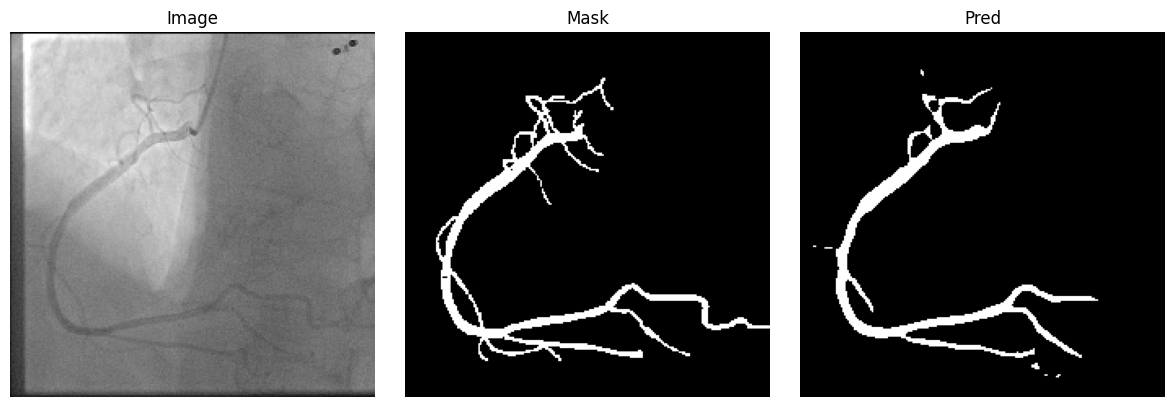

In [8]:
import matplotlib.pyplot as plt

def show_img_mask_pred(img, mask, pred):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for ax, data, title in zip(axs, [img, mask, pred], ['Image', 'Mask', 'Pred']):
        ax.imshow(data, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_img_mask_pred(test_imgs[0], test_masks[0], test_preds[0])